# Goal

This notebook checks model performance on a test set.

**With gratitude to**:
- https://github.com/mattiaspaul/OBELISK
-  https://github.com/kbressem/faimed3d/blob/main/examples/3d_segmentation.md

In [1]:
# DATALOADER PARAMS
bs          = 4
nepochs     = 30
num_workers = 2

# PREPROCESS (Isotropic, PadResize)
# iso       = 3
# maxs      = [87, 90, 90]

iso       = 2
maxs      = [144, 144, 144]

# Train:Valid:Test = 60:20:20
train_pct, valid_pct = .60, .20

# Paths

In [2]:
import os

# Paths to (1) code (2) data
code_src    = "/gpfs/home/gologr01"
data_src    = "/gpfs/data/oermannlab/private_data/DeepPit"

# stored code
deepPit_src = f"{code_src}/DeepPit"
obelisk_src = f"{code_src}/OBELISK"

# stored data
label_src   = f"{data_src}/PitMRdata/samir_labels"
run_src     = f"{data_src}/runs"

# UMich 
# code src: "/home/labcomputer/Desktop/Rachel"
# data src: "../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/"

# dsets and metadata
dsetmd_src   = f"{data_src}/saved_dset_metadata"
dsets_src    = f"{data_src}/PitMRdata"
sample_src   = f"{data_src}/sample_other_dsets"

# print
print("Folders in dset src: ", end=""); print(*os.listdir(dsets_src), sep=", ")

# print
print("Folders in data src: ", end=""); print(*os.listdir(data_src), sep=", "); print("*"*50)
print("Folders in label src (data w labels): ", end=""); print(*os.listdir(label_src), sep=", "); print("*"*50)

Folders in dset src: ABVIB_49_235.zip, AIBL_2-263.zip, ICMB, ABVIB (1).zip, central.xnat.org, ADNI, PPMI, Oasis_long, samir_labels, ACRIN-FMISO-Brain, LGG-1p19qDeletion, REMBRANDT, ICMB_1005-1297.zip, AIBL, CPTAC-GBM, PPMI_3107-3326.zip, ADNI1_002_0023.zip, TCGA-LGG, ABVIB, ABIDE, AIBL.zip
Folders in data src: saved_landmarks, saved_models, sample_other_dsets, Labels, saved_dset_metadata, runs, saved_preds, PitMRdata
**************************************************
Folders in label src (data w labels): 50155-50212, PPMI_3107-3326, 50313-50372, 50213-50312, 50373-50453, 50002-50153, AIBL_2-263, ICMB_1005-1297, ADNI1_002_0023, ABVIB_49_235
**************************************************


# Imports

In [3]:
%load_ext autoreload
%autoreload 2

In [18]:
# imports (# Piece)
from transforms import AddChannel, Iso, PadSz,\
                       ZScale, \
                       GNoise, GBlur,\
                       RandBright, RandContrast, \
                       RandDihedral, MattAff
        
from condseg_transforms import (
    AddAtlas, IsoAtlas, 
    ZScaleAtlas, AddChAtlas, 
    MattAffAtlas, ConcatChannel)


from helpers.losses import dice, dice_score, dice_loss, dice_ce_loss, log_cosh_dice_loss, perim_loss

# MONAI
from monai.losses        import DiceLoss
from monai.metrics       import DiceMetric
from monai.networks.nets import VNet, UNet, Regressor

# Utilities
import os, sys, gc, time, pickle, glob, re
from pathlib import Path

# Input IO
import SimpleITK as sitk
import meshio

# Numpy and Pandas
import numpy as np
import pandas as pd
from pandas import DataFrame as DF

# Fastai + distributed training
from fastai              import *
from fastai.torch_basics import *
from fastai.basics       import *
from fastai.distributed  import *
from fastai.callback.all import SaveModelCallback
from fastai.callback.tensorboard import TensorBoardCallback

# PyTorch
from torch import nn

# Obelisk
sys.path.append(deepPit_src)
sys.path.append(obelisk_src)

# OBELISK
from utils  import *
from models import obelisk_visceral, obeliskhybrid_visceral

# Helper functions
from helpers.preprocess import get_data_dict_n4, mask2bbox, print_bbox, get_bbox_size, print_bbox_size
from helpers.general    import sitk2np, np2sitk, print_sitk_info, lrange, lmap, print_hardware_stats, cut, rm_prefix, rm_prefix_item, get_param
from helpers.viz        import viz_axis, viz_compare_inputs, viz_compare_outputs
from helpers.time       import time_one_batch, get_time_id

# Labelled items

In [5]:
folders = sorted(Path(label_src).iterdir(), key=os.path.getmtime, reverse=True)
# print(*[Path(f).name for f in folders], sep="\n")

cross_lbl_folders = folders[:5]
abide_lbl_folders = folders[5:]

print("Cross", *cross_lbl_folders, sep="\n"); print("*"*50)
print("Abide", *abide_lbl_folders, sep="\n")

Cross
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/PPMI_3107-3326
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/ICMB_1005-1297
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/AIBL_2-263
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/ADNI1_002_0023
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/ABVIB_49_235
**************************************************
Abide
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50373-50453
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50313-50372
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50213-50312
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50155-50212
/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50002-50153


In [6]:
# Open matched paths = (seg_folder, mr_folder)
with open(f"{dsetmd_src}/first_100_matched_segs.txt", "r") as f:
    lst = f.read().splitlines()
    # str to tuple
    cross_seg_paths, cross_mr_paths = zip(*[eval(s) for s in lst])

# items = (mr_path, seg_path)
cross_lbl_items = [(f"{mr}/las_n4.nii", f"{seg}/seg.pt") for mr, seg in zip(cross_mr_paths, cross_seg_paths)]

# print
print("5 items: ", *rm_prefix_item(cross_lbl_items, prefix=[sample_src, label_src], skip=len(cross_lbl_items)//5), sep="\n")

5 items: 
('AIBL/263/MPRAGE_ADNI_confirmed/2009-11-20_09_25_07.0/S91498/las_n4.nii', 'AIBL_2-263/263/seg.pt')
('ICMB/UCLA_1297/SAG_MPRAGE_8_CHANNEL/2006-01-31_17_05_45.0/S17045/las_n4.nii', 'ICMB_1005-1297/UCLA_1297/seg.pt')
('ADNI1_Complete_1Yr_1.5T/018_S_0369/MPR-R____N3__Scaled/2006-10-27_14_30_45.0/S21216/las_n4.nii', 'ADNI1_002_0023/018_S_0369/seg.pt')
('ABVIB/69/t1_mpr_sag-WS/2009-03-31_08_33_40.0/S346032/las_n4.nii', 'ABVIB_49_235/69/seg.pt')
('PPMI/3126/Sag_MPRAGE_GRAPPA/2016-08-24_11_49_25.0/S510960/las_n4.nii', 'PPMI_3107-3326/3126/seg.pt')


In [7]:
# Get ABIDE data dict
abide_data = {}
for folder in abide_lbl_folders: abide_data.update(get_data_dict_n4(folder))

# Convert data dict => items (path to MR, path to Segm tensor)
abide_lbl_items = list(abide_data.values())
print(f"Full lbl items: {len(abide_lbl_items)}")

# remove bad label 50132
abide_weird_lbls = [50132, 50403]
def is_weird(fn): return any([str(lbl) in fn for lbl in abide_weird_lbls])
   
abide_lbl_items = [o for o in abide_lbl_items if not is_weird(o[0])]
print(f"Removed {len(abide_weird_lbls)} weird, new total lbl items: {len(abide_lbl_items)}")

# print
print("5 items from ABIDE: ", 
      *rm_prefix_item(abide_lbl_items, prefix=[label_src, label_src], skip=len(abide_lbl_items)//5), 
      sep="\n")

Full lbl items: 335
Removed 2 weird, new total lbl items: 333
5 items from ABIDE: 
('50373-50453/50385/MP-RAGE/2000-01-01_00_00_00.0/S164676/ABIDE_50385_MRI_MP-RAGE_br_raw_20120830175317987_S164676_I328686_corrected_n4.nii', '50373-50453/50385/seg.pt')
('50313-50372/50339/MP-RAGE/2000-01-01_00_00_00.0/S165279/ABIDE_50339_MRI_MP-RAGE_br_raw_20120830223012265_S165279_I329289_corrected_n4.nii', '50313-50372/50339/seg.pt')
('50213-50312/50266/MP-RAGE/2000-01-01_00_00_00.0/S166137/ABIDE_50266_MRI_MP-RAGE_br_raw_20120905100113104_S166137_I330316_corrected_n4.nii', '50213-50312/50266/seg.pt')
('50155-50212/50195/MP-RAGE/2000-01-01_00_00_00.0/S164734/ABIDE_50195_MRI_MP-RAGE_br_raw_20120830181423530_S164734_I328744_corrected_n4.nii', '50155-50212/50195/seg.pt')
('50002-50153/50125/MP-RAGE/2000-01-01_00_00_00.0/S164649/ABIDE_50125_MRI_MP-RAGE_br_raw_20120830174129152_S164649_I328659_corrected_n4.nii', '50002-50153/50125/seg.pt')
('50002-50153/50003/MP-RAGE/2000-01-01_00_00_00.0/S164416/ABIDE_500

# Items

In [8]:
items = cross_lbl_items #[cross_lbl_items[i] for i in range(0,100,5)]
print(f"Cross label items: {len(items)}")

# pretty print
print("All items: ", *rm_prefix_item(items, prefix=[sample_src, label_src]), sep=f"\n{'*'*100}\n")

# print(*[(mr[len(cross_mr_src)+1:],seg[len(label_src)+1:]) for mr,seg in items], sep=f"\n{'*'*100}\n")

Cross label items: 100
All items: 
****************************************************************************************************
('AIBL/263/MPRAGE_ADNI_confirmed/2009-11-20_09_25_07.0/S91498/las_n4.nii', 'AIBL_2-263/263/seg.pt')
****************************************************************************************************
('AIBL/80/MPRAGE_ADNI_confirmed/2010-09-24_12_23_33.0/S104499/las_n4.nii', 'AIBL_2-263/80/seg.pt')
****************************************************************************************************
('AIBL/97/MPRAGE_ADNI_confirmed/2010-04-23_11_07_35.0/S104530/las_n4.nii', 'AIBL_2-263/97/seg.pt')
****************************************************************************************************
('AIBL/126/MPRAGE_ADNI_confirmed/2014-02-13_11_40_30.0/S760500/las_n4.nii', 'AIBL_2-263/126/seg.pt')
****************************************************************************************************
('AIBL/17/MPRAGE_ADNI_confirmed/2011-01-28_12_56_23.0/S113471

# Param

In [9]:
model_fns = sorted(Path(run_src).iterdir(), key=os.path.getmtime, reverse=True)
model_fns = [str(p) for p in model_fns]
print(*[model_fn[len(run_src):] for model_fn in model_fns], sep="\n")

/model_Regressor_loss_mse_loss_iso_2mm_pad_144_144_144_bs_2_epochs_300_time_1626987054_Thu_Jul_07_2021_hr_16_min_50
/model_Regressor_loss_mse_loss_iso_2mm_pad_144_144_144_bs_2_epochs_300_time_1626979958_Thu_Jul_07_2021_hr_14_min_52
/model_Regressor_loss_mse_loss_iso_3mm_pad_96_96_96_bs_5_epochs_300_time_1626979440_Thu_Jul_07_2021_hr_14_min_44
/model_Regressor_loss_mse_loss_iso_3mm_pad_96_96_96_bs_5_epochs_60_time_1626979151_Thu_Jul_07_2021_hr_14_min_39
/model_Regressor_loss_mse_loss_iso_3mm_pad_96_96_96_bs_5_epochs_60_time_1626978449_Thu_Jul_07_2021_hr_14_min_27
/model_Regressor_loss_mse_loss_iso_3mm_pad_96_96_96_bs_2_epochs_60_time_1626977448_Thu_Jul_07_2021_hr_14_min_10
/model_Regressor_loss_mse_loss_iso_3mm_pad_96_96_96_bs_2_epochs_60_time_1626977389_Thu_Jul_07_2021_hr_14_min_09
/model_Regressor_loss_mse_loss_iso_3mm_pad_96_96_96_bs_2_epochs_60_time_1626977336_Thu_Jul_07_2021_hr_14_min_08
/model_Regressor_loss_mse_loss_iso_3mm_pad_96_96_96_bs_2_epochs_60_time_1626977214_Thu_Jul_07_2

In [10]:
model_fn = "model_Regressor_loss_mse_loss_iso_2mm_pad_144_144_144_bs_2_epochs_300_time_1626979958_Thu_Jul_07_2021_hr_14_min_52"

In [12]:
# choose model
# model_fn = Path(model_fns[0]).name

# get param
model_type = get_param(model_fn, "model_", "_loss")
loss_type  = get_param(model_fn, "loss_", "_iso")
iso_sz     = get_param(model_fn, "iso_", "mm")
maxs       = get_param(model_fn, "pad_", "_bs")
bs         = get_param(model_fn, "bs_", "_epochs")
nepochs    = get_param(model_fn, "epochs_", "_time")

# print
#print("Model name: ", model_fn)
print(f"Model type: {model_type}. Loss type: {loss_type}. Iso: {iso_sz}. PadResize to: {maxs}. bs = {bs}. nepochs = {nepochs}.")
print(f"Model Name: {model_fn}")

Model type: Regressor. Loss type: mse_loss. Iso: 2. PadResize to: [144, 144, 144]. bs = 2. nepochs = 300.
Model Name: model_Regressor_loss_mse_loss_iso_2mm_pad_144_144_144_bs_2_epochs_300_time_1626979958_Thu_Jul_07_2021_hr_14_min_52


# Transforms

In [13]:
# tfms
if model_type.startswith("CONDSEG"):
    item_tfms  = [AddAtlas(items), IsoAtlas(iso_sz), PadSz(maxs)]
    batch_tfms = [ZScaleAtlas(), AddChAtlas(), ConcatChannel()]

else:
    item_tfms  = [Iso(iso_sz), PadSz(maxs)]
    batch_tfms = [ZScale(), AddChannel()]

# Dataloaders

In [14]:
# time it
start = time.time()

# tls
tls = TfmdLists(items, item_tfms)

# dls
dls = tls.dataloaders(bs=bs, after_batch=batch_tfms, num_workers=num_workers)

# GPU
dls = dls.cuda()

# end timer
elapsed = time.time() - start
print(f"Elapsed time: {elapsed} s for {len(items)} items")

Elapsed time: 3.97633957862854 s for 100 items


In [15]:
# test get one batch
b = dls.one_batch()
print(type(b), b[0].shape, b[1].shape)
print(f"bs = {bs}, n_train = {len(dls.train_ds)}, n_valid = {len(dls.valid_ds)}, n_test_items = {len(items)}")

<class 'tuple'> torch.Size([2, 1, 144, 144, 144]) torch.Size([2, 1, 144, 144, 144])
bs = 2, n_train = 100, n_valid = 0, n_test_items = 100


# Models

In [20]:
full_res = maxs

In [21]:
device = torch.device("cuda:0")
model = Regressor(
    in_shape   = (1,*full_res), 
    out_shape  = (6), 
    channels   = (16, 32, 64, 128, 256),
    strides    = (2, 2, 2, 2), 
    kernel_size=3, 
    num_res_units=2, 
    act='PRELU', 
    norm='INSTANCE', 
    dropout=None, 
    bias=True
).to(device)

# Loss

In [22]:
def get_bbox_vals(i,j,k):
    imin, imax = torch.where(i)[0][[0, -1]]
    jmin, jmax = torch.where(j)[0][[0, -1]]
    kmin, kmax = torch.where(k)[0][[0, -1]]
    
    # inclusive indices
    return torch.tensor([imin, imax+1, jmin, jmax+1, kmin, kmax+1])

In [23]:
def batch_get_bbox(yb):
    # BCDHW => BDHW
    masks =yb.squeeze(1).byte()
    
    # batchwise BDHW
    # BDHW -> BHW -> BW
    # BDHW -> BHW -> BH
    # BDHW -> BDW -> BD 
    bk = torch.any(torch.any(masks, dim=1), dim=1) # 0 -> 1,2 -> 1 -> 2 left
    bj = torch.any(torch.any(masks, dim=1), dim=2) # 0 -> 1,2 -> 2 -> 1 left
    bi = torch.any(torch.any(masks, dim=2), dim=2) # 1 -> 0,2 -> 0 -> 0 left

    # for b in batch
    return torch.stack([get_bbox_vals(i,j,k) for i,j,k in zip(bi,bj,bk)], dim=0)

In [24]:
# bbox2mask
def bbox2mask(bbox, sz=full_res):
    # float bbox -> integer
    a,b,c,d,e,f = torch.round(bbox).int()
    arr = torch.zeros(full_res)
    arr[a:b, c:d, e:f] = 1
    return arr

In [25]:
# metric
def dice_score_regression(preds, targets):
    pred_masks = torch.stack([bbox2mask(bbox) for bbox in preds], dim=0).to(preds.get_device())
    
    dice_loss = dice(pred_masks, targets.squeeze())
    #loss = Variable(dice_loss, requires_grad = True)
    return dice_loss

In [26]:
# from fastai
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

def mse_bin_mask_loss(preds, targets):
    """
    preds   = Bx6 coords
    targets = BCDHW, where C = 1
    -> target_bbox = Bx6
    -> preds scaled to be [0,144]
    -> MSE(preds, target_bbox)
    """
    # get bbox B x (imin imax jmin jmax kmin kmax)
    target_bbox = batch_get_bbox(targets).to(targets.get_device())
    
    # scale preds between 0-size
    preds = sigmoid_range(preds, lo=0, hi=full_res[0])

    # print debug
    #print(target_bbox.dtype, preds.dtype)
    
#     print("Preds: ", preds)
#     print("Target bbox: ", target_bbox)
#     print(f"MSE: {torch.nn.MSELoss()(preds.float(), target_bbox.float()):.2f}")
          
    # get MSE between prediction and target bbox
    return torch.nn.MSELoss(reduction='sum')(preds.float(), target_bbox.float())

# Learner

In [27]:
import gc
gc.collect()

70

In [29]:
learn = Learner(dls       = dls, 
                model     = model, 
                loss_func = mse_bin_mask_loss,
                metrics   = mse_bin_mask_loss)

# load model fname w/o .pth extension
learn.load(f"{run_src}/{model_fn}/model")

In [31]:
# check
print("Check")
b = dls.one_batch()
xb,yb = b
print(f"Batch: {len(b)}. xb: {xb.shape}, yb: {yb.shape}")
predb = learn.model(xb)
print(f"Pred batch: {predb.shape}")
loss = learn.loss_func(predb, yb)
print(f"Loss: {loss}")

Check
Batch: 2. xb: torch.Size([2, 1, 144, 144, 144]), yb: torch.Size([2, 1, 144, 144, 144])
Pred batch: torch.Size([2, 6])
Loss: 667.1275634765625


In [32]:
# all predictions, 67 items, 4 workers, 15sec
start = time.time()
predictions, targets = learn.get_preds(ds_idx=0)
elapsed = time.time() - start

print(f"Elapsed: {elapsed:0.2f} s for {len(items)} items.")

Elapsed: 28.88 s for 100 items.


In [33]:
# 30 sec for 67 test items (2 CPU workers)
learn.validate(ds_idx=0)

(#2) [916.7173461914062,916.7173461914062]

In [34]:
print(predictions.shape, targets.shape)
print(targets[0].shape, predictions[0].shape)

torch.Size([100, 6]) torch.Size([100, 1, 144, 144, 144])
torch.Size([1, 144, 144, 144]) torch.Size([6])


In [41]:
scaled = sigmoid_range(predictions, lo=0, hi=full_res[0])

In [44]:
scaled = scaled.round().long()
scaled

tensor([[ 66,  84,  67,  87,  51,  70],
        [ 66,  70,  82,  87,  51,  57],
        [ 67,  79,  85,  95,  50,  57],
        [ 65,  73,  79,  89,  49,  54],
        [ 64,  74,  76,  95,  47,  53],
        [ 61,  78,  82,  96,  45,  54],
        [ 66,  79,  72,  94,  43,  51],
        [ 70,  77,  81,  99,  43,  53],
        [ 72,  79,  77,  94,  52,  70],
        [ 67,  78,  78,  89,  51,  58],
        [ 69,  78,  85,  98,  45,  55],
        [ 61,  74,  72,  88,  50,  66],
        [ 68,  82,  83,  98,  47,  57],
        [ 69,  75,  71,  89,  51,  57],
        [ 66,  81,  81,  90,  49,  53],
        [ 67,  76,  85,  97,  45,  50],
        [ 69,  83,  83,  96,  47,  55],
        [ 64,  76,  75,  95,  49,  59],
        [ 63,  77,  76,  94,  52,  71],
        [ 65,  73,  69,  94,  39,  56],
        [ 69,  81,  74,  90,  50,  62],
        [ 66,  76,  75,  90,  44,  54],
        [ 69,  76,  71,  89,  45,  59],
        [ 71,  83,  71,  85,  48,  65],
        [ 67,  86,  69,  84,  48,  63],


In [45]:
targets.shape

torch.Size([100, 1, 144, 144, 144])

In [46]:
gt_bboxs = batch_get_bbox(targets)

In [48]:
for i in range(len(gt_bboxs)):
    print(f"{i}:")
    print("GT  : ", gt_bboxs[i])
    print("Pred: ", scaled[i])
    print("*"*50, "\n")

0:
GT  :  tensor([67, 77, 60, 81, 66, 83])
Pred:  tensor([66, 84, 67, 87, 51, 70])
************************************************** 

1:
GT  :  tensor([64, 81, 72, 89, 69, 80])
Pred:  tensor([66, 70, 82, 87, 51, 57])
************************************************** 

2:
GT  :  tensor([62, 82, 79, 95, 65, 77])
Pred:  tensor([67, 79, 85, 95, 50, 57])
************************************************** 

3:
GT  :  tensor([62, 83, 76, 91, 64, 75])
Pred:  tensor([65, 73, 79, 89, 49, 54])
************************************************** 

4:
GT  :  tensor([65, 83, 71, 87, 66, 78])
Pred:  tensor([64, 74, 76, 95, 47, 53])
************************************************** 

5:
GT  :  tensor([63, 81, 76, 93, 61, 74])
Pred:  tensor([61, 78, 82, 96, 45, 54])
************************************************** 

6:
GT  :  tensor([63, 83, 75, 90, 56, 68])
Pred:  tensor([66, 79, 72, 94, 43, 51])
************************************************** 

7:
GT  :  tensor([63, 83, 78, 95, 61, 74])
Pred:

In [26]:
# xb,yb = learn.dls.one_batch()
# init_loss = learn.loss_func(learn.model(xb), yb)
# print(init_loss)

# a = learn.model(xb)
# print(a.shape)

# overall_dice = dice_score(predictions, targets)
# print(overall_dice)

# Test set: Prediction Dice Distribution

In [27]:
start = time.time()

indiv_dices = [dice_score(predictions[i].unsqueeze(0), targets[i].unsqueeze(0)) for i in range(len(targets))]
elapsed = time.time() - start

print(f"Elapsed: {elapsed:0.2f} s for {len(targets)} items.")

Elapsed: 44.86 s for 100 items.


Elapsed: 0.06 s for 100 items.


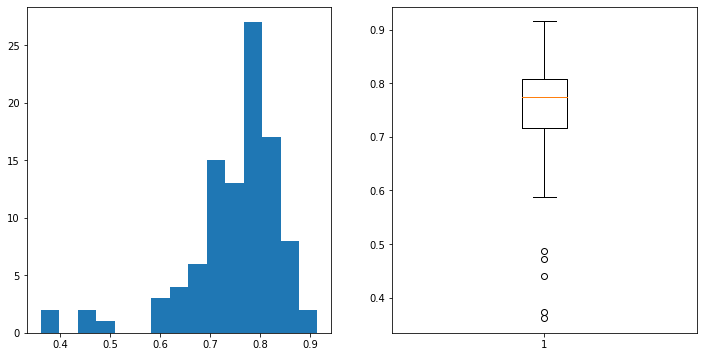

In [28]:
start = time.time()

# sort dices from low to high
sorted_dice_idxs  = sorted(range(len(indiv_dices)), key=lambda i:indiv_dices[i].item()) 
np_indiv_dices = np.array([indiv_dices[i].item() for i in sorted_dice_idxs])

# plot
fig1, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
ax0.hist(np_indiv_dices, bins="auto")
ax1.boxplot(np_indiv_dices)

# time
elapsed = time.time() - start
print(f"Elapsed: {elapsed:0.2f} s for {len(targets)} items.")

In [29]:
# num dices under 0.6
threshold = 0.6
lows = [(i,dice) for i,dice in zip(sorted_dice_idxs, np_indiv_dices) if dice < threshold]

if len(lows) > 0:
    low_dice_idxs, low_dices = zip(*lows)
else:
    low_dice_idxs, low_dices = [],[]

In [31]:
print(len(low_dices), low_dice_idxs)
print(*[f"Dice {indiv_dices[i].item()}, \n fn: {items[i][0][len(sample_src):]} \n" for i in low_dice_idxs], sep="\n")

7 (43, 82, 95, 0, 47, 93, 58)
Dice 0.3619261682033539, 
 fn: /ADNI1_Complete_1Yr_1.5T/023_S_0031/MPR-R__GradWarp__B1_Correction__N3__Scaled/2006-10-30_10_58_33.0/S21467/las_n4.nii 

Dice 0.3730723559856415, 
 fn: /PPMI/3113/MPRAGE_GRAPPA/2011-08-01_14_19_06.0/S120881/las_n4.nii 

Dice 0.44001975655555725, 
 fn: /PPMI/3157/MPRAGE_GRAPPA/2011-02-07_10_44_54.0/S113900/las_n4.nii 

Dice 0.4720041751861572, 
 fn: /AIBL/263/MPRAGE_ADNI_confirmed/2009-11-20_09_25_07.0/S91498/las_n4.nii 

Dice 0.48673906922340393, 
 fn: /ADNI1_Complete_1Yr_1.5T/014_S_0658/MPR__GradWarp__B1_Correction__N3__Scaled/2007-04-19_11_38_16.0/S29990/las_n4.nii 

Dice 0.5878485441207886, 
 fn: /PPMI/3107/MPRAGE_GRAPPA2/2016-04-06_13_56_12.0/S426371/las_n4.nii 

Dice 0.5969253778457642, 
 fn: /ADNI1_Complete_1Yr_1.5T/014_S_0563/MPR__GradWarp__B1_Correction__N3__Scaled/2006-07-05_12_06_54.0/S16079/las_n4.nii 



In [141]:
np.asarray(indiv_dices).mean()

0.7487774

# Viz best, worst

In [32]:
tpred_bboxs = [mask2bbox(np.asarray(torch.argmax(predictions[i], dim=0))) for i in range(len(predictions))]

In [33]:
worst_idx = low_dice_idxs[0]
best_idx  = low_dice_idxs[-1]
print("Worst. Idx = ", worst_idx, "Dice: ", indiv_dices[worst_idx], items[worst_idx][0]); print()
print("Best. Idx = ", best_idx, "Dice: ",   indiv_dices[best_idx], items[best_idx][0])

Worst. Idx =  43 Dice:  tensor(0.3619) /gpfs/data/oermannlab/private_data/DeepPit/sample_other_dsets/ADNI1_Complete_1Yr_1.5T/023_S_0031/MPR-R__GradWarp__B1_Correction__N3__Scaled/2006-10-30_10_58_33.0/S21467/las_n4.nii

Best. Idx =  58 Dice:  tensor(0.5969) /gpfs/data/oermannlab/private_data/DeepPit/sample_other_dsets/ADNI1_Complete_1Yr_1.5T/014_S_0563/MPR__GradWarp__B1_Correction__N3__Scaled/2006-07-05_12_06_54.0/S16079/las_n4.nii


In [34]:
# get dirs
worst_fn = items[worst_idx][0]
best_fn  = items[best_idx][0]

print(f"Worst fname: {worst_fn[len(label_src):]}"); print()
print(f"best fname: {best_fn[len(label_src):]}")

for fn in (worst_fn, best_fn):
    # get stated direction
    sitk_obj = sitk.ReadImage(fn, sitk.sitkFloat32)
    sitk_dir = sitk_obj.GetDirection()

    # get stated orientation
    orient = sitk.DICOMOrientImageFilter()
    sitk_ori = orient.GetOrientationFromDirectionCosines(sitk_dir)
    
    # print
    print(f"Dir {sitk_dir}, Ori {sitk_ori}")

Worst fname: I1_Complete_1Yr_1.5T/023_S_0031/MPR-R__GradWarp__B1_Correction__N3__Scaled/2006-10-30_10_58_33.0/S21467/las_n4.nii

best fname: I1_Complete_1Yr_1.5T/014_S_0563/MPR__GradWarp__B1_Correction__N3__Scaled/2006-07-05_12_06_54.0/S16079/las_n4.nii
Dir (1.0, -1.658299685100472e-09, -1.3749789523247764e-18, -1.6582996713370015e-09, -1.0, -1.6582997668113165e-09, -1.3749789779662025e-18, -1.658299685100472e-09, 1.0), Ori LAS
Dir (1.0, -4.9431175301935335e-09, -1.221720490885319e-17, -4.943117300478792e-09, -1.0, -4.943117310389842e-09, -1.2217205249477291e-17, -4.9431175301935335e-09, 1.0), Ori LAS


1: 
Bbox coords: (67, 77, 63) to (86, 93, 76). Size: 19, 16, 13.
Bounding box coord: from location (77, 63) of slice 67 to location (93, 76) of slice 86.
2: 
Bbox coords: (60, 75, 66) to (81, 93, 80). Size: 21, 18, 14.
Bounding box coord: from location (75, 66) of slice 60 to location (93, 80) of slice 81.


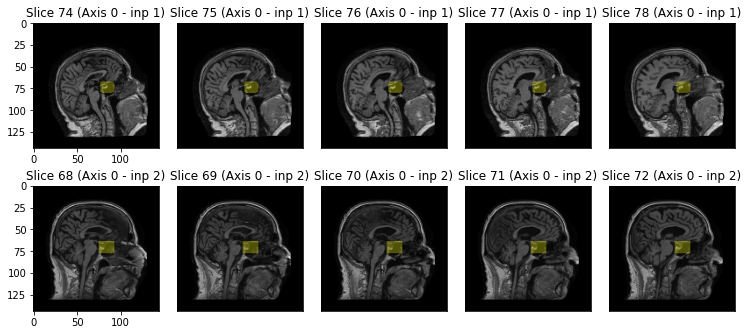

1: 
Bbox coords: (67, 77, 63) to (86, 93, 76). Size: 19, 16, 13.
Bounding box coord: from location (77, 63) of slice 67 to location (93, 76) of slice 86.
2: 
Bbox coords: (60, 75, 66) to (81, 93, 80). Size: 21, 18, 14.
Bounding box coord: from location (75, 66) of slice 60 to location (93, 80) of slice 81.


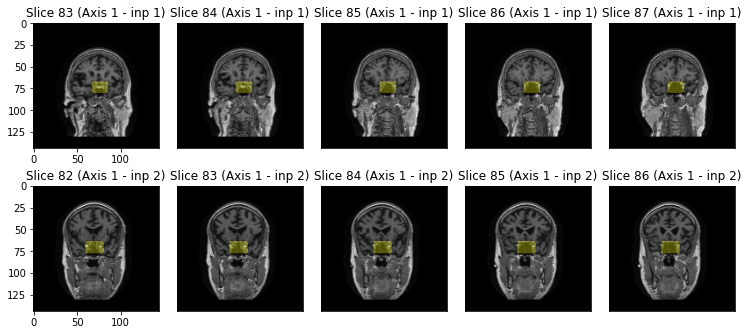

1: 
Bbox coords: (67, 77, 63) to (86, 93, 76). Size: 19, 16, 13.
Bounding box coord: from location (77, 63) of slice 67 to location (93, 76) of slice 86.
2: 
Bbox coords: (60, 75, 66) to (81, 93, 80). Size: 21, 18, 14.
Bounding box coord: from location (75, 66) of slice 60 to location (93, 80) of slice 81.


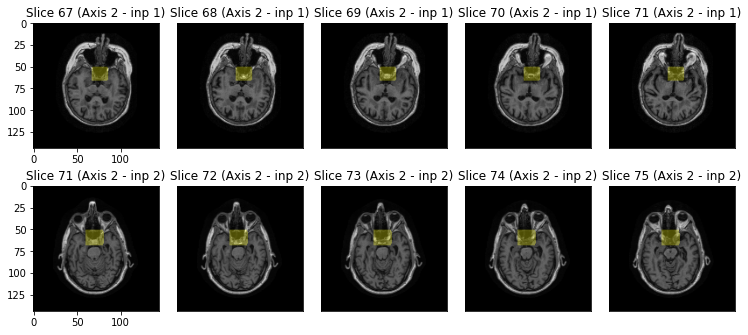

In [35]:
for axis in range(3):
    viz_compare_inputs(tls[worst_idx], tls[best_idx], axis=axis)

# Worst

In [36]:
print(predictions[worst_idx].shape)
print(targets[worst_idx].shape)

torch.Size([2, 144, 144, 144])
torch.Size([1, 144, 144, 144])


In [37]:
# print worst idx file
if model_type.startswith("CONDSEG"):
    print(f"fname: {test_items[worst_idx]}")

    # output: Iso(self.new_sp)(input1), Iso(self.new_sp)(atlas1)
    input1, atlas1 = tls[worst_idx]
    
    # apply ZScale
    worst_mr, worst_seg = ZScale()(input1)
    
    # print
    print(f"Worst mr and seg shape: ", worst_mr.shape, worst_seg.shape)

    # get prediction, ground truth target
    pred, target = predictions[worst_idx], targets[worst_idx].squeeze()

    print("Pred, target shape: ", pred.shape, target.shape)
    print("GT bbox", mask2bbox(np.asarray(target)))
    print("GT bbox and Pred bbox: ", gt_bboxs[worst_idx], pred_bboxs[worst_idx])

    viz_compare_outputs(worst_mr, target, pred)

In [38]:
# for n_worst in range(len(low_dice_idxs)):
#     worst_idx = low_dice_idxs[n_worst]

#     worst_mr, worst_seg = tls[worst_idx]
#     #print(f"Worst mr and seg shape: ", worst_mr.shape, worst_seg.shape)

#     pred, target = predictions[worst_idx], targets[worst_idx].squeeze()

#     dice = dice_score(pred.unsqueeze(0), target.unsqueeze(0).unsqueeze(0))
#     print(f"Worst #{n_worst}. Dice {dice:.3f}")
#     print(f"fn: {items[worst_idx][0][len(cross_mr_src)+1:]}")
#     print(f"*"*100)
#     #pred = torch.argmax(predictions[worst_idx], dim=0)
#     #print("Pred, target shape: ", pred.shape, target.shape, dls.train_ds[worst_idx][0].shape)
#     #print("Check that target == train_ds[worst_idx]", np.array_equal(dls.train_ds[worst_idx][1], target))

#     mr = dls.train_ds[worst_idx][0]
#     #print("GT bbox", mask2bbox(np.asarray(target)))
#     print("GT bbox and Pred bbox: ", gt_bboxs[worst_idx], pred_bboxs[worst_idx])

#     viz_compare_outputs(mr, target, pred)

# Convert

In [125]:
from nbconvert import HTMLExporter
import codecs
import nbformat

notebook_name = '03b_test_model_copy.ipynb'
output_file_name = notebook_name[:-6] + "_conn_redo" + '.html'

exporter = HTMLExporter()
output_notebook = nbformat.read(notebook_name, as_version=4)

output, resources = exporter.from_notebook_node(output_notebook)
codecs.open(output_file_name, 'w', encoding='utf-8').write(output)

# Post-processing

1. Largest Connect Label

In [40]:
worst_idx = low_dice_idxs[0]
worst_pred = torch.argmax(predictions[worst_idx], dim=0)
worst_targ = targets[worst_idx].squeeze()

assert np.array_equal(worst_targ, dls.train_ds[worst_idx][1])

In [41]:
len(low_dice_idxs)

7

# Training Labels Shape Statistics

In [43]:
# from http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/35_Segmentation_Shape_Analysis.html

lbl_sizes = []
for idx, item in enumerate(abide_lbl_items):
    # target
    target = torch.transpose(torch.load(item[1]).long(), 0, 2)
    
    # target
    stats = sitk.LabelShapeStatisticsImageFilter()
    stats.Execute(sitk.ConnectedComponent(sitk.GetImageFromArray(target)))
    targ_label_sizes = [ stats.GetNumberOfPixels(l) for l in stats.GetLabels()]

    lbl_sizes.append(targ_label_sizes)

In [44]:
len_lbls = [len(lst) for lst in lbl_sizes]

In [45]:
flat_lbl_szs = [a[0] for a in lbl_sizes]

(array([166., 139.,   6.,   0.,   2.,   4.,   3.,   7.,   2.,   4.]),
 array([  7185. ,  16989.8,  26794.6,  36599.4,  46404.2,  56209. ,
         66013.8,  75818.6,  85623.4,  95428.2, 105233. ]),
 <BarContainer object of 10 artists>)

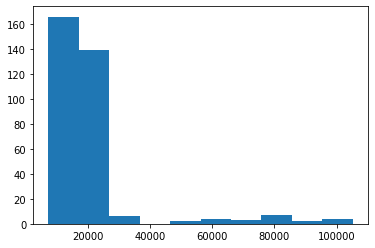

In [46]:
plt.hist(np.asarray(flat_lbl_szs))

In [47]:
sorted_idxs = sorted(range(len(abide_lbl_items)), key=lambda i: flat_lbl_szs[i], reverse=True)

In [57]:
large_outliers    = [(flat_lbl_szs[i], abide_lbl_items[i][0]) for i in sorted_idxs if flat_lbl_szs[i] > 40_000]

In [67]:
print(f"n outliers: {len(large_outliers)}, total abide items: {len(abide_lbl_items)}")
print(*rm_prefix([a[1] for a in large_outliers], prefix=label_src, do_sort=True), sep=f"\n{'*'*50}'\n")

n outliers: 22, total abide items: 333
50373-50453/50432/MP-RAGE/2000-01-01_00_00_00.0/S165246/ABIDE_50432_MRI_MP-RAGE_br_raw_20120830221233070_S165246_I329256_corrected_n4.nii
**************************************************'
50373-50453/50433/MP-RAGE/2000-01-01_00_00_00.0/S165170/ABIDE_50433_MRI_MP-RAGE_br_raw_20120830213241835_S165170_I329180_corrected_n4.nii
**************************************************'
50373-50453/50434/MP-RAGE/2000-01-01_00_00_00.0/S164325/ABIDE_50434_MRI_MP-RAGE_br_raw_20120830151057793_S164325_I328319_corrected_n4.nii
**************************************************'
50373-50453/50435/MP-RAGE/2000-01-01_00_00_00.0/S164516/ABIDE_50435_MRI_MP-RAGE_br_raw_20120830163805210_S164516_I328519_corrected_n4.nii
**************************************************'
50373-50453/50436/MP-RAGE/2000-01-01_00_00_00.0/S165360/ABIDE_50436_MRI_MP-RAGE_br_raw_20120830231340925_S165360_I329370_corrected_n4.nii
**************************************************'
50373-50453

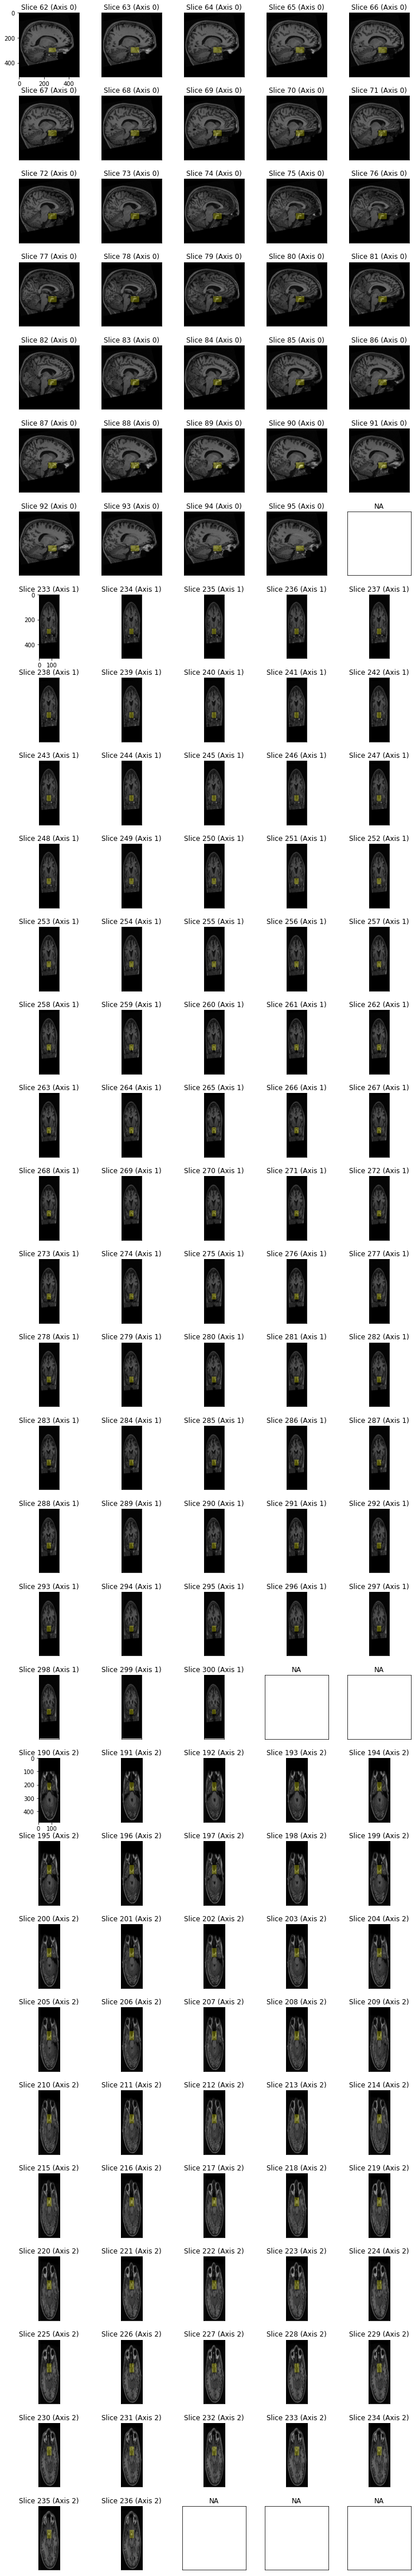

In [46]:
# viz largest

idx = sorted_idxs[0]
sz = flat_lbl_szs[idx]
item = abide_lbl_items[idx]

seg = torch.load(item[1]).long()
bbox = mask2bbox(np.asarray(seg))

mr = sitk.ReadImage(item[0], sitk.sitkFloat32)
mr = sitk2np(mr)
seg = np.asarray(seg)

viz_axis(np_arr = mr, \
            bin_mask_arr   = seg,     color1 = "yellow",  alpha1=0.3, \
            slices=lrange(*bbox[0:2]), fixed_axis=0, \
            axis_fn = np.rot90, \
            title   = "Axis 0", \

            np_arr_b = mr, \
            bin_mask_arr_b   = seg,     color1_b = "yellow",  alpha1_b=0.3, \
            slices_b = lrange(*bbox[2:4]), fixed_axis_b=1, \
            title_b  = "Axis 1", \

            np_arr_c = mr, \
            bin_mask_arr_c   = seg,     color1_c = "yellow",  alpha1_c=0.3, \
            slices_c = lrange(*bbox[4:6]), fixed_axis_c=2, \
            title_c = "Axis 2", \
  
        ncols = 5, hspace=0.3, fig_mult=2) 

Fn: ADNI1_Complete_1Yr_1.5T/023_S_0031/MPR-R__GradWarp__B1_Correction__N3__Scaled/2006-10-30_10_58_33.0/S21467/las_n4.nii.
****************************************************************************************************


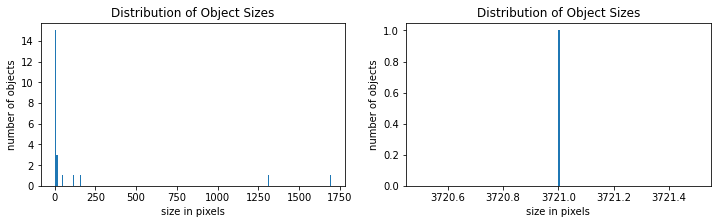

Fn: PPMI/3113/MPRAGE_GRAPPA/2011-08-01_14_19_06.0/S120881/las_n4.nii.
****************************************************************************************************


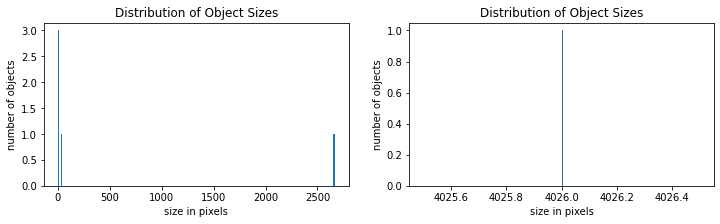

Fn: PPMI/3157/MPRAGE_GRAPPA/2011-02-07_10_44_54.0/S113900/las_n4.nii.
****************************************************************************************************


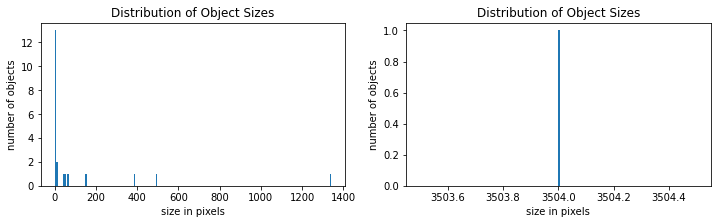

Fn: AIBL/263/MPRAGE_ADNI_confirmed/2009-11-20_09_25_07.0/S91498/las_n4.nii.
****************************************************************************************************


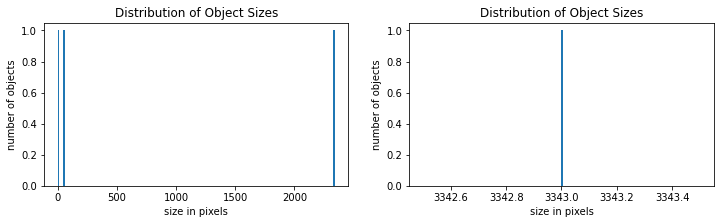

Fn: ADNI1_Complete_1Yr_1.5T/014_S_0658/MPR__GradWarp__B1_Correction__N3__Scaled/2007-04-19_11_38_16.0/S29990/las_n4.nii.
****************************************************************************************************


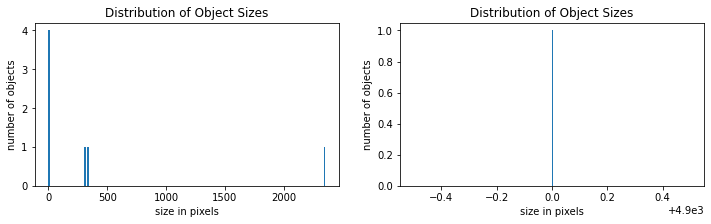

Fn: PPMI/3107/MPRAGE_GRAPPA2/2016-04-06_13_56_12.0/S426371/las_n4.nii.
****************************************************************************************************


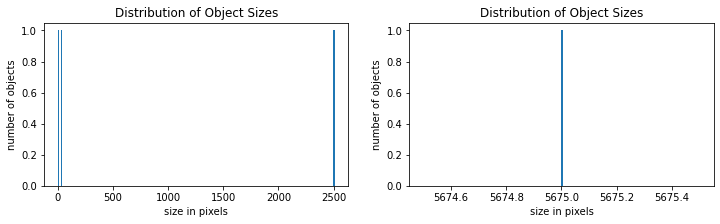

Fn: ADNI1_Complete_1Yr_1.5T/014_S_0563/MPR__GradWarp__B1_Correction__N3__Scaled/2006-07-05_12_06_54.0/S16079/las_n4.nii.
****************************************************************************************************


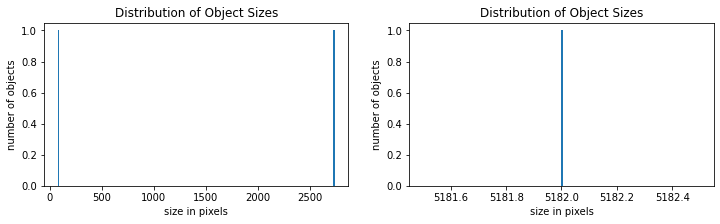

In [119]:
# from http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/35_Segmentation_Shape_Analysis.html

nrows = len(low_dice_idxs)

for n_worst in range(nrows):
    row = n_worst
    
    # get pred, target
    worst_idx = low_dice_idxs[n_worst]
    worst_pred = torch.argmax(predictions[worst_idx], dim=0)
    worst_targ = targets[worst_idx].squeeze()

    assert np.array_equal(worst_targ, dls.train_ds[worst_idx][1])

    # prediction
    #BinaryImageToLabelMapFilter
    stats = sitk.LabelShapeStatisticsImageFilter()
    stats.Execute(sitk.ConnectedComponent(sitk.GetImageFromArray(worst_pred)))
    pred_label_sizes = [ stats.GetNumberOfPixels(l) for l in stats.GetLabels()]

    # target
    stats = sitk.LabelShapeStatisticsImageFilter()
    stats.Execute(sitk.ConnectedComponent(sitk.GetImageFromArray(worst_targ)))
    targ_label_sizes = [ stats.GetNumberOfPixels(l) for l in stats.GetLabels()]

    # Calculate Dice before and after largest only
    dice_score_orig = dice_score(predictions[worst_idx].unsqueeze(0), worst_targ.unsqueeze(0).unsqueeze(0))
    
    # print
    print(f"Fn: {items[worst_idx][0][len(cross_mr_src)+1:]}."); print("*"*100)
    
    # plot predicted (row 0) and target ground truth (row 1)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

    # row 0 = predicted
    axes[0].hist(pred_label_sizes,bins=200)
    axes[0].set_title("Distribution of Object Sizes")
    axes[0].set_xlabel("size in pixels")
    axes[0].set_ylabel("number of objects")

    # row 1 = target ground truth
    axes[1].hist(targ_label_sizes,bins=200)
    axes[1].set_title("Distribution of Object Sizes")
    axes[1].set_xlabel("size in pixels")
    axes[1].set_ylabel("number of objects")

    plt.show()

# Get largest connected component

In [70]:
predictions[0].shape

torch.Size([2, 144, 144, 144])

In [93]:
# source sitk 36_Microscopy_Colocalization_Distance_Analysis.html
def get_largest_connected_component(binary_seg):
    # tensor to sitk
    binary_seg = sitk.GetImageFromArray(binary_seg)
    
    # connected components in sitkSeg
    labeled_seg = sitk.ConnectedComponent(binary_seg)

    # re-order labels according to size (at least 1_000 pixels = 10x10x10)
    labeled_seg = sitk.RelabelComponent(labeled_seg, minimumObjectSize=1000, sortByObjectSize=True)

    # return segm of largest label
    binary_seg = labeled_seg == 1
    
    # sitk to tensor
    return torch.tensor(sitk.GetArrayFromImage(binary_seg))

In [113]:
ax_slice_idxs[0]

[[44, 69], [35], [13]]

Worst #0
ADNI1_Complete_1Yr_1.5T/023_S_0031/MPR-R__GradWarp__B1_Correction__N3__Scaled/2006-10-30_10_58_33.0/S21467/las_n4.nii
Dice: 0.3619 -> 0.0000, delta: -0.3619

 ************************************************** 



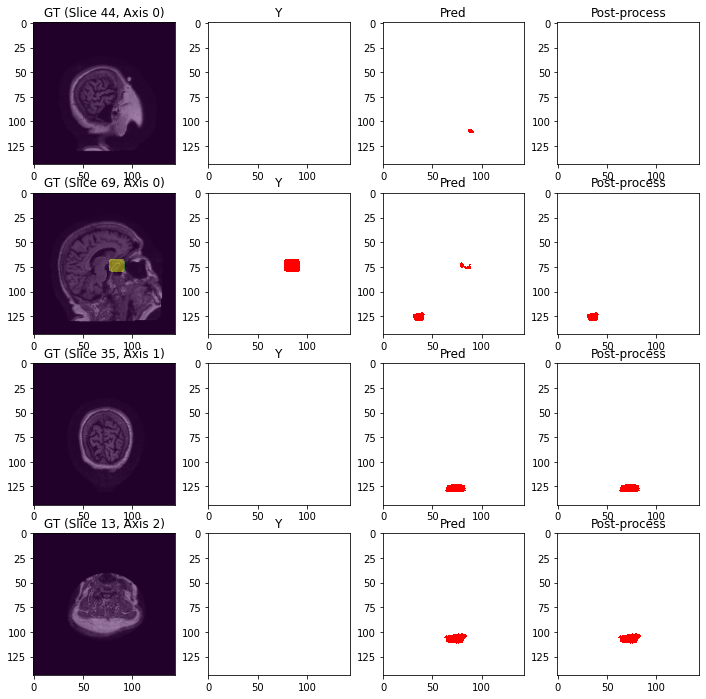

Worst #1
PPMI/3113/MPRAGE_GRAPPA/2011-08-01_14_19_06.0/S120881/las_n4.nii
Dice: 0.3731 -> 0.3759, delta: 0.0028

 ************************************************** 



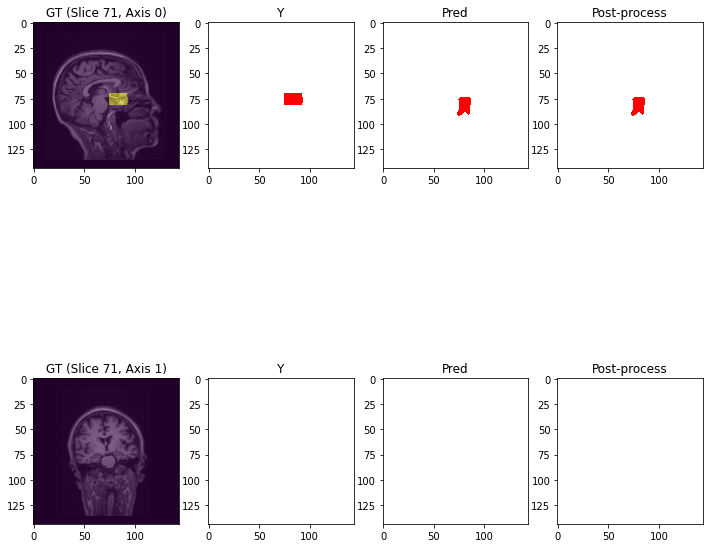

Worst #2
PPMI/3157/MPRAGE_GRAPPA/2011-02-07_10_44_54.0/S113900/las_n4.nii
Dice: 0.4400 -> 0.5518, delta: 0.1118

 ************************************************** 



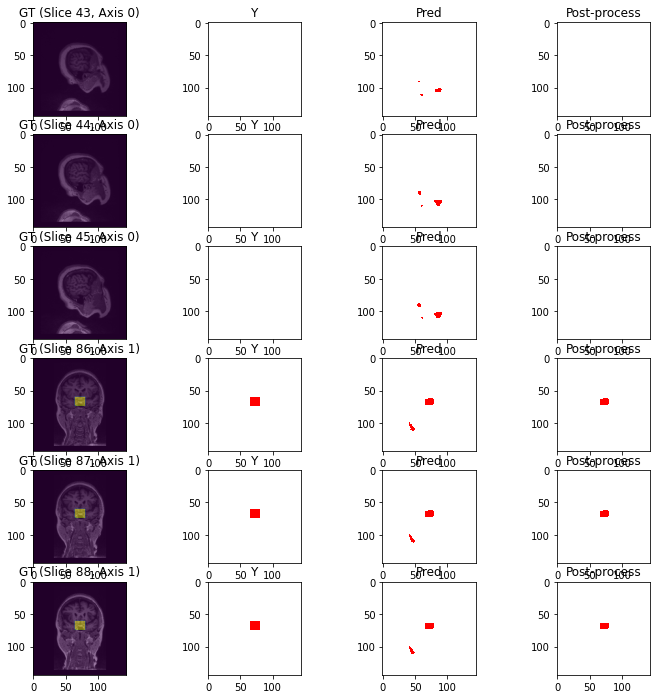

Worst #3
AIBL/263/MPRAGE_ADNI_confirmed/2009-11-20_09_25_07.0/S91498/las_n4.nii
Dice: 0.4720 -> 0.4762, delta: 0.0042

 ************************************************** 



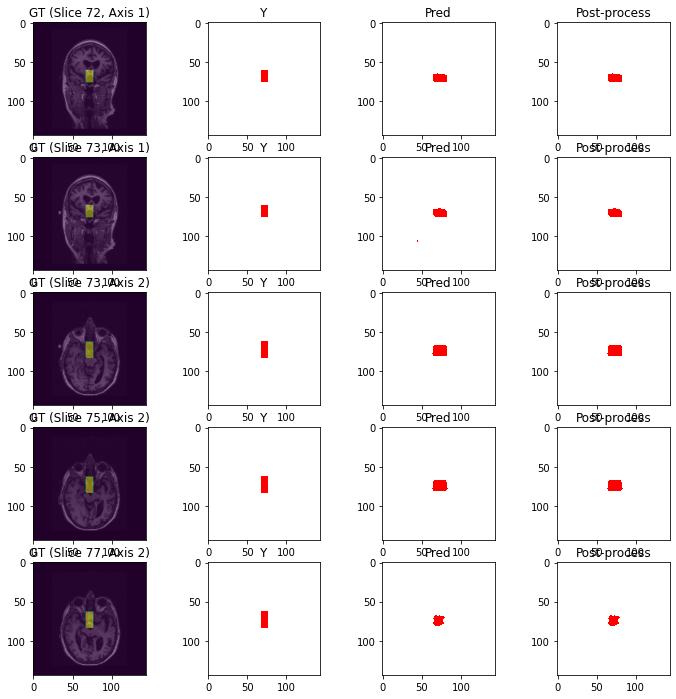

Worst #4
ADNI1_Complete_1Yr_1.5T/014_S_0658/MPR__GradWarp__B1_Correction__N3__Scaled/2007-04-19_11_38_16.0/S29990/las_n4.nii
Dice: 0.4867 -> 0.5316, delta: 0.0448

 ************************************************** 



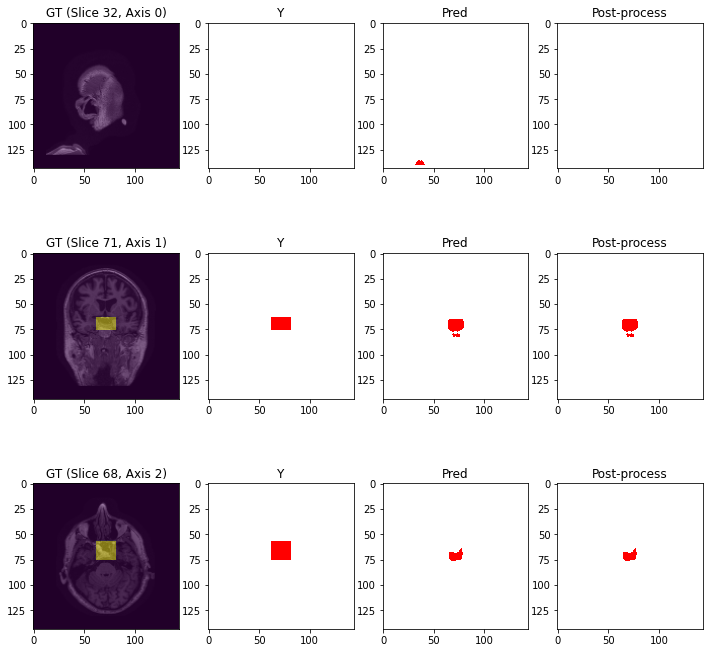

Worst #5
PPMI/3107/MPRAGE_GRAPPA2/2016-04-06_13_56_12.0/S426371/las_n4.nii
Dice: 0.5878 -> 0.5899, delta: 0.0021

 ************************************************** 



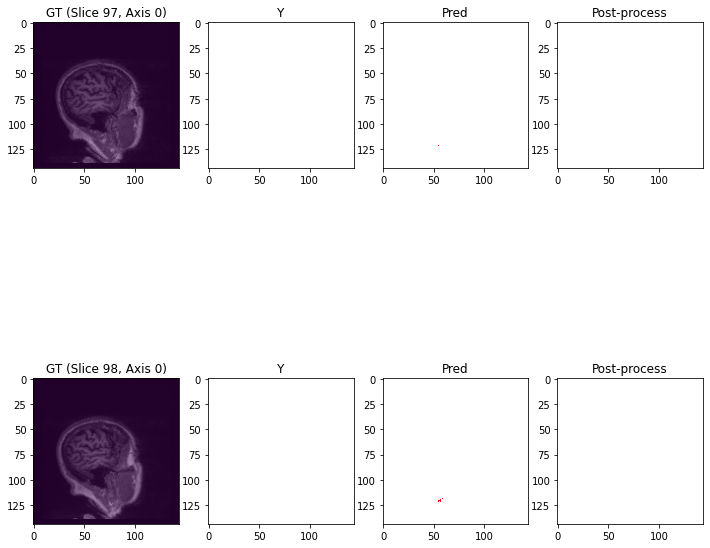

Worst #6
ADNI1_Complete_1Yr_1.5T/014_S_0563/MPR__GradWarp__B1_Correction__N3__Scaled/2006-07-05_12_06_54.0/S16079/las_n4.nii
Dice: 0.5969 -> 0.6030, delta: 0.0060

 ************************************************** 



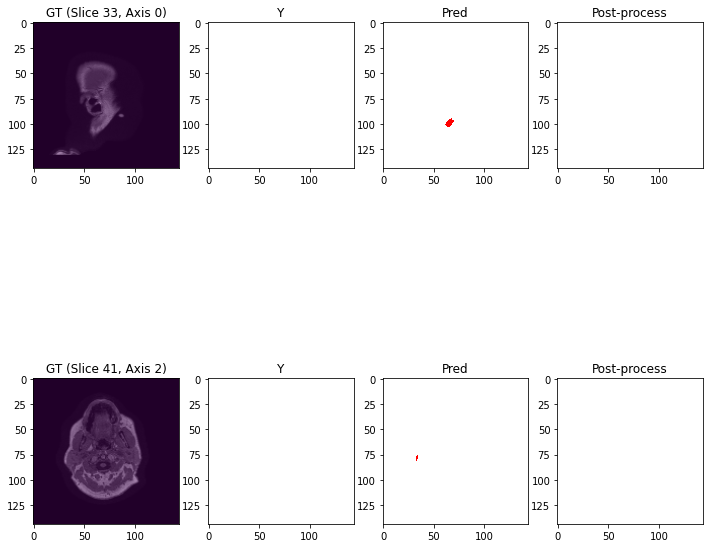

In [124]:
# Check

# viz - slice 71, axis 0
ax_slice_idxs = [
    [[44,69],[35],[13]],             # worst #0
    [[71],[71],[]],                  # worst #1
    [[43,44,45],[86,87,88],[]],      # worst #2
    [[],[72,73],[73,75,77]],         # worst #3
    [[32],[71],[68]],                # worst #4
    [[97,98],[],[]],                 # worst #5
    [[33],[],[41]],                  # worst #6
]
    
for i in range(len(low_dice_idxs)):
    idx       = low_dice_idxs[i]

    # get mr and mk (ground truth)
    x = dls.train_ds[idx][0]
    y = targets[idx].squeeze()

    # get prediction & process
    y_pred = predictions[idx].argmax(0)
    y_post = get_largest_connected_component(y_pred)

    orig_dice = dice(y_pred, targets[idx])
    new_dice  = dice(y_post, targets[idx])

    assert indiv_dices[idx] == orig_dice

    
    # print
    print(f"Worst #{i}")
    print(f"{cut(items[idx][0], prefix=sample_src)}")
    print(f"Dice: {orig_dice:.4f} -> {new_dice:.4f}, delta: {new_dice-orig_dice:.4f}")
    print("\n", "*"*50, "\n")
    
    # viz - slice 71, axis 0
    slice_idxs = ax_slice_idxs[i]
    tot = sum([len(a) for a in slice_idxs])

    from matplotlib import colors
    prob_cmap  = "GnBu" #"hot" https://matplotlib.org/stable/tutorials/colors/colormaps.html 
    bin_cmap2  = colors.ListedColormap(['white', 'red'])

    _, axes = plt.subplots(nrows=tot, ncols=4, figsize=(12,12))

    count = 0
    for axis_idx in range(3):
        slice_lst = slice_idxs[axis_idx]
        for slice_idx in slice_lst:
            ax = axes[count]
            
            # ground truth x+y
            ax[0].imshow(np.rot90(np.take(x, slice_idx, axis=axis_idx)), cmap=plt.cm.gray)
            ax[0].imshow(np.rot90(np.take(y, slice_idx, axis=axis_idx)), alpha=0.5)

            # y, y_pred, y_post
            ax[1].imshow(np.rot90(np.take(y,      slice_idx, axis=axis_idx)), cmap=bin_cmap2)
            ax[2].imshow(np.rot90(np.take(y_pred, slice_idx, axis=axis_idx)), cmap=bin_cmap2)
            ax[3].imshow(np.rot90(np.take(y_post, slice_idx, axis=axis_idx)), cmap=bin_cmap2)

            ax[0].set_title(f"GT (Slice {slice_idx}, Axis {axis_idx})")
            ax[1].set_title("Y")
            ax[2].set_title("Pred")
            ax[3].set_title("Post-process")
            
            count += 1

    plt.show()

In [134]:
# post-process

# y_pred = predictions[idx].argmax(0)
# y_post = get_largest_connected_component(y_pred)
    
post_preds = [get_largest_connected_component(pred.argmax(0)) for pred in predictions]

In [135]:
start = time.time()

post_indiv_dices = [dice(post_pred, target) for post_pred, target in zip(post_preds, targets)]
elapsed = time.time() - start

print(f"Elapsed: {elapsed:0.2f} s for {len(targets)} items.")

Elapsed: 0.38 s for 100 items.


Elapsed: 0.06 s for 100 items.


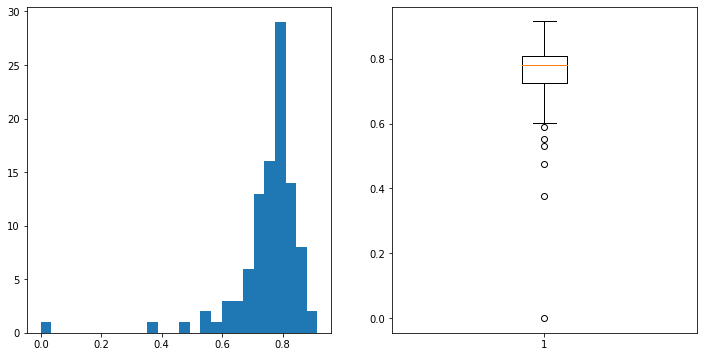

In [136]:
start = time.time()

# sort dices from low to high
post_sorted_dice_idxs  = sorted(range(len(post_indiv_dices)), key=lambda i:post_indiv_dices[i].item()) 
post_np_indiv_dices = np.array([post_indiv_dices[i].item() for i in post_sorted_dice_idxs])

# plot
fig1, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
ax0.hist(post_np_indiv_dices, bins="auto")
ax1.boxplot(post_np_indiv_dices)

# time
elapsed = time.time() - start
print(f"Elapsed: {elapsed:0.2f} s for {len(targets)} items.")

In [137]:
# num dices under 0.6
threshold = 0.6
post_lows = [(i,dice) for i,dice in zip(post_sorted_dice_idxs, post_np_indiv_dices) if dice < threshold]

if len(post_lows) > 0:
    post_low_dice_idxs, post_low_dices = zip(*post_lows)
else:
    post_low_dice_idxs, post_low_dices = [],[]

print(len(post_low_dices), post_low_dice_idxs)
print(*[f"Dice {post_indiv_dices[i].item()}, \n fn: {items[i][0][len(sample_src):]} \n" for i in post_low_dice_idxs], sep="\n")

6 (43, 82, 0, 47, 95, 93)
Dice 0.0, 
 fn: /ADNI1_Complete_1Yr_1.5T/023_S_0031/MPR-R__GradWarp__B1_Correction__N3__Scaled/2006-10-30_10_58_33.0/S21467/las_n4.nii 

Dice 0.37591513991355896, 
 fn: /PPMI/3113/MPRAGE_GRAPPA/2011-08-01_14_19_06.0/S120881/las_n4.nii 

Dice 0.47615694999694824, 
 fn: /AIBL/263/MPRAGE_ADNI_confirmed/2009-11-20_09_25_07.0/S91498/las_n4.nii 

Dice 0.531586229801178, 
 fn: /ADNI1_Complete_1Yr_1.5T/014_S_0658/MPR__GradWarp__B1_Correction__N3__Scaled/2007-04-19_11_38_16.0/S29990/las_n4.nii 

Dice 0.5517953038215637, 
 fn: /PPMI/3157/MPRAGE_GRAPPA/2011-02-07_10_44_54.0/S113900/las_n4.nii 

Dice 0.5899315476417542, 
 fn: /PPMI/3107/MPRAGE_GRAPPA2/2016-04-06_13_56_12.0/S426371/las_n4.nii 



In [139]:
np.asarray(post_indiv_dices).mean()

0.7524596

In [133]:
# check_item = items[low_dice_idxs[4]]
# targ = targets[low_dice_idxs[4]].squeeze().cpu()
# print(mask2bbox(np.asarray(targ)))

# stats = sitk.LabelShapeStatisticsImageFilter()
# stats.Execute(sitk.ConnectedComponent(sitk.GetImageFromArray(targ)))
# targ_label_sizes = [ stats.GetNumberOfPixels(l) for l in stats.GetLabels()]
# print(targ_label_sizes)

# plt.imshow(targ[70])

# Best

In [55]:
print(f"fname: {test_items[best_idx]}")

best_mr, best_seg = tls[best_idx]
print(f"Best mr and seg shape: ", best_mr.shape, best_seg.shape)

pred, target = predictions[best_idx], targets[best_idx].squeeze()

#pred = torch.argmax(predictions[worst_idx], dim=0)
print("Pred, target shape: ", pred.shape, target.shape, dls.train_ds[best_idx][0].shape)
print("Check that target == train_ds[best_idx]", np.array_equal(dls.train_ds[best_idx][1], target))

mr = dls.train_ds[best_idx][0]
print("GT bbox", mask2bbox(np.asarray(target)))
print("GT bbox and Pred bbox: ", gt_bboxs[best_idx], pred_bboxs[best_idx])


fname: ('/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50313-50372/50356/MP-RAGE/2000-01-01_00_00_00.0/S164625/ABIDE_50356_MRI_MP-RAGE_br_raw_20120830173000462_S164625_I328633_corrected_n4.nii', '/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata/samir_labels/50313-50372/50356/seg.pt')
Best mr and seg shape:  torch.Size([144, 144, 144]) torch.Size([144, 144, 144])
Pred, target shape:  torch.Size([2, 144, 144, 144]) torch.Size([144, 144, 144]) torch.Size([144, 144, 144])
Check that target == train_ds[best_idx] True
GT bbox (64, 82, 72, 88, 48, 58)
GT bbox and Pred bbox:  (64, 82, 72, 88, 48, 58) (64, 83, 72, 88, 47, 59)


# $\Delta$ bbox

In [ ]:
print(predictions.shape, predictions[0].shape, targets[0].shape, torch.argmax(predictions[0], dim=0).shape)

In [ ]:
print(gt_bboxs[0], pred_bboxs[0])

In [ ]:
# compare sizes
def get_bbox_size(imin, imax, jmin, jmax, kmin, kmax): return imax - imin, jmax-jmin, kmax-kmin
gt_bbox_szs   = [get_bbox_size(*gt) for gt in gt_bboxs]
pred_bbox_szs = [get_bbox_size(*pr) for pr in pred_bboxs]

In [ ]:
import pandas as pd
gt_df = pd.DataFrame(gt_bbox_szs, columns =['i', 'j', 'k'])
pred_df = pd.DataFrame(pred_bbox_szs, columns =['i', 'j', 'k'])

In [ ]:
gt_bbox_szs

In [ ]:
pred_bbox_szs

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
gt_df.boxplot(column=['i', 'j', 'k'],   ax=axes[0])
pred_df.boxplot(column=['i', 'j', 'k'], ax = axes[1])

In [ ]:
print(list(pred_bbox_szs[i] for i in low_dice_idxs))

In [ ]:
_, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,4))
pred_df.hist(column=['i', 'j', 'k'], ax=axes[0])
gt_df.hist(column=['i', 'j', 'k'], ax=axes[1])

In [ ]:
def bbox_missing(gt_bbox, pred_bbox):
    # for i_min: missing if gt < pred
    # for i_max: missing if gt > pred
    mins = [max(pred_bbox[i] - gt_bbox[i], 0) for i in (0, 2, 4)]
    maxs = [max(gt_bbox[i] - pred_bbox[i], 0) for i in (1, 3, 5)]
    missing = [x for t in zip(mins, maxs) for x in t]
    return missing

In [ ]:
# test
print(bbox_missing((0,1,2,3,4,5), (0,2,2,3,4,5)))
print(bbox_missing((0,1,2,3,4,5), (1,2,2,3,4,5)))
print(bbox_missing((0,1,2,3,4,5), (-2,2,2,3,4,5)))

In [ ]:
missings = [bbox_missing(gt, pred) for gt, pred in zip(gt_bboxs, pred_bboxs)]

In [ ]:
missings_df = pd.DataFrame(missings, columns =['imin', 'imax', 'jmin', 'jmax', 'kmin', 'kmax'])

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

missings_df.hist(column=['imin', 'imax', 'jmin', 'jmax', 'kmin', 'kmax'], ax=axes[0])
missings_df.boxplot(column=['imin', 'imax', 'jmin', 'jmax', 'kmin', 'kmax'], ax=axes[1])

In [ ]:
for col in ['imin', 'imax', 'jmin', 'jmax', 'kmin', 'kmax']:
    nonzero = [v for v in missings_df[col].values if v != 0]
    max_nonzero = max(nonzero) if len(nonzero) > 0 else "NA"
    print(f"{col}: n = {len(nonzero)}, max diff = {max_nonzero}")

# Resize Pred

In [ ]:
# pad to new size
class ReverseTfm(ItemTransform):
    split_idx = None
    
    def __init__(self, iso_sz, const_sz):
        self.iso_sz   = iso_sz
        self.const_sz = const_sz
    
    def encodes(self, item):
        
        # decode item
        pred, im_path = item
        
        # Get shape post-Iso
        mr = sitk.ReadImage(im_path, sitk.sitkFloat32)

        # iso resize
        orig_sp = mr.GetSpacing()
        orig_sz = mr.GetSize()
        new_sz = [int(round(osz*ospc/self.iso_sz)) for osz,ospc in zip(orig_sz, orig_sp)]
        
        # Pads used to go from iso_sz => const_sz
        pad = [x-y for x,y in zip(self.const_sz, new_sz)]
        pad = [a for amt in pad for a in (amt//2, amt-amt//2)]
        pad.reverse()
        
        # Undo pad: const_sz => new_sz
        shape0, shape1, shape2 = pred.shape
        a,b,c,d,e,f            = pad
        pred_no_pad = pred[e:shape0-f, c:shape1-d, a:shape2-b]

        # Undo iso (add batch dim for interpolate)
        while pred_no_pad.ndim < 5: 
            pred_no_pad = pred_no_pad.unsqueeze(0)
            
        return F.interpolate(pred_no_pad.float(), size = orig_sz, mode = 'nearest').squeeze().long()


In [ ]:
pred = predictions[0]
pred_mk   = torch.argmax(pred, dim=0)
nii = test_items[0][0]

print(pred_mk.shape, nii, sep="\n")

In [ ]:
im_path, segm_path = test_items[0]
orig_mk = torch.load(f"{str(Path(segm_path).parent)}/seg.pt").float()

RTfm = ReverseTfm(iso_sz = iso_sz, const_sz = maxs)
rev_pred = RTfm((pred_mk, nii))
print(f"Orig mask shape: {orig_mk.shape}, Reversed Iso({iso_sz} shape: {rev_pred.shape})")
print("Orig mask", mask2bbox(np.asarray(orig_mk)))
print("Pred mask", mask2bbox(np.asarray(rev_pred)))

# End

In [ ]:
print("Done")

# Old

# change orientation

In [43]:
# import nibabel as nb
# from nibabel.orientations import inv_ornt_aff

# # https://github.com/nipy/nipype/blob/70add2941679146307a5bd0769358fc8bcdff17c/nipype/interfaces/image.py#L110
# from nibabel.orientations import (
#             axcodes2ornt, ornt_transform, inv_ornt_aff)

# def get_affine(from_code, to_code, im):
#     orig_ornt = axcodes2ornt(from_code)
#     targ_ornt = axcodes2ornt(to_code)
#     transform = ornt_transform(orig_ornt, targ_ornt)
#     affine_xfm = inv_ornt_aff(transform, im.shape)
    
#     # apply
#     t_arr   = nb.apply_orientation(im, transform)
#     new_aff = affine_xfm.dot(inv_ornt_aff(transform, im.shape))
#     #reoriented = img.__class__(t_arr, new_aff, img.header)
    
#     return t_arr

In [44]:
# worst_mr, worst_seg = tls[worst_idx]
# worst_mr_corr  = get_affine("LAS", "SRA", worst_mr)
# worst_seg_corr = get_affine("LAS", "SRA", worst_seg)

# print("Shapes: mr/seg, corrected mr/seg")
# print(worst_mr.shape, worst_seg.shape, worst_mr_corr.shape, worst_seg_corr.shape)

In [45]:
# # check correction worked
# for axis in range(3):
#     viz_compare_inputs((worst_mr_corr, worst_seg_corr), tls[best_idx], axis=axis)

In [46]:
# worst_item_corr = (worst_mr_corr.copy(), worst_seg_corr.copy())
# print(worst_mr_corr.shape, worst_seg_corr.shape)

# corr_tls = TfmdLists([worst_item_corr], [])
# corr_dls = corr_tls.dataloaders(bs=1, after_batch=batch_tfms, num_workers=num_workers)

# corr_dls = corr_dls.cuda()

# b = corr_dls.one_batch()
# print(b[0].shape, b[1].shape)

In [47]:
# z_worst_mr_corr, z_worst_seg_corr = b[0].squeeze(), b[1].squeeze()
# print(z_worst_mr_corr.shape, z_worst_seg_corr.shape)

In [48]:
# worst_pred_corr = learn.model(b[0])
# print(worst_pred_corr.shape)

In [49]:
# viz_compare_outputs(worst_mr_corr, worst_seg_corr, worst_pred_corr[0].cpu())